## Downloading Dataset From Kaggle

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
#Download your api kaggle.jdon from kaggle and upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"282f290157256acc09141ba03f1ccae2"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c shopee-product-matching

100% 1.68G/1.68G [00:54<00:00, 52.4MB/s]
100% 1.68G/1.68G [00:54<00:00, 33.0MB/s]


In [5]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/shopee-product-matching.zip'

with ZipFile(file_name, 'r') as zipex:
  zipex.extractall()
  print('Done')

Done


In [16]:
!pip -q install sentence-transformers

     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 4.9 MB 65.4 MB/s 
     |████████████████████████████████| 1.3 MB 61.7 MB/s 
     |████████████████████████████████| 163 kB 73.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.4 MB/s 


## Importing The Libraries

In [50]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from tqdm.notebook import tqdm
import pickle
import torch
import warnings
warnings.filterwarnings("ignore")

## Reading The Dataset

In [13]:
train_df = pd.read_csv(r'/content/train.csv')
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [4]:
label_group_df = train_df.groupby('label_group')
label_group_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34244,train_945815402,fff1222750374ddbed82b17c8bd2766d.jpg,b0cbce308fcdcc64,Baterai Batre Battery Xiaomi Redmi Note 3 BM46...,3091541662
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


## Data Visualization

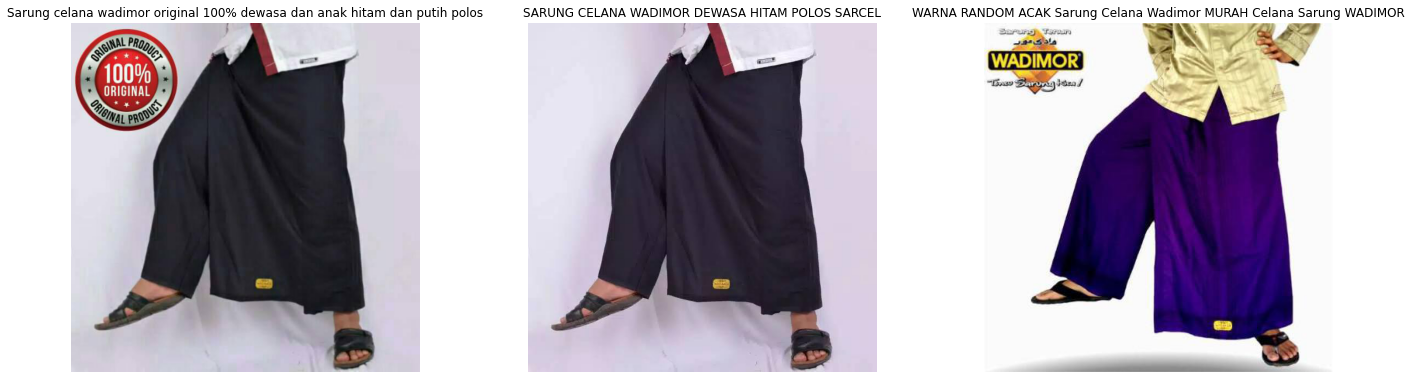

In [8]:
for group_name,group_df in label_group_df:
  path = '/content/train_images/'
  images_list = group_df.image.tolist()
  title_list = group_df.title.tolist()
  n_images = len(group_df.image)
  figure, axes = plt.subplots(1,n_images,  figsize = (20,10)) 
  for imagetitle, ax, imgname in zip(title_list, axes, images_list):
    img = plt.imread(path+imgname) 
    ax.set_title(imagetitle)
    ax.axis('off')   
    ax.imshow(img)

  break 
plt.tight_layout()
plt.show()    

## Dividing The Data Into Train & Test

In [15]:
x = train_df
y = train_df.pop('label_group')
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y,test_size=0.4,random_state=0)

## Importing and Setting Up Pretrained Models

In [24]:
from sentence_transformers import SentenceTransformer, util
textmodel = SentenceTransformer('stsb-distilbert-base')
textmodel.max_seq_length = 132

In [28]:
img_size = 224
size = (img_size,img_size)
imagemodel = tf.keras.applications.MobileNet(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet' )

## Generating Text and Image Embeddings

In [29]:
def get_text_embeddings(model,text):
  return model.encode(text, convert_to_tensor=True)

In [30]:
def get_image_embeddings(model,image_path):
  image = tf.keras.preprocessing.image.load_img(image_path,target_size= size)
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])
  img_embeddings = model(input_arr)
  meanImgEmb1 = np.mean(img_embeddings,axis =0)
  meanImgEmb2 = np.mean(meanImgEmb1,axis=0)
  meanImgEmb = np.mean(meanImgEmb2,axis=0)
  return meanImgEmb

In [34]:
def get_combine_embeddings(textmodel, imagemodel, x_train):
  text_embeddings={}
  image_embeddings={}
  for index,row in  tqdm(x_train.iterrows()):
    image_path = '/content/train_images/'+row[1]
    txt_emb = get_text_embeddings(textmodel,str(row[3]))
    img_emb = get_image_embeddings(imagemodel,image_path)
    text_embeddings[row[0]] = txt_emb
    image_embeddings[row[0]] = img_emb
  return text_embeddings,image_embeddings

In [35]:
text_embeddings,image_embeddings = get_combine_embeddings(textmodel, imagemodel, x_train)

0it [00:00, ?it/s]

## Saving Embeddings

In [40]:
def save_embeddings(text_embeddings, image_embeddings):
  with open('./text_embeddings','wb') as handle:
    pickle.dump(text_embeddings,handle)
  with open('./image_embeddings','wb') as handle:
    pickle.dump(image_embeddings,handle)
  print('Embeddings Saved Successfully')  

In [41]:
save_embeddings(text_embeddings, image_embeddings)

Embeddings Saved Successfully


## Getting Nearest Neighbors

In [132]:
def generated_data_for_kneigh(x_train, text_embeddings, image_embeddings):
  key_list=[]
  cemb_list=[]
  image_list=[]
  title_list=[]
  for index, row in tqdm(x_train.iterrows()):
    txt_emb = torch.tensor(text_embeddings[row[0]])
    img_emb = torch.tensor(image_embeddings[row[0]])
    
    txt_emb_copy = txt_emb.clone().detach().cpu()
    img_emb_copy = img_emb.clone().detach().cpu()


    cmb_emb = np.concatenate((txt_emb_copy,img_emb_copy),axis=0)
    norm = np.linalg.norm(cmb_emb)
    cmb_emb_normal = cmb_emb/norm
    
    key_list.append(row[0])
    cemb_list.append(cmb_emb_normal)
    image_list.append(row[1])
    title_list.append(row[3])
  return key_list, cemb_list, image_list, title_list
key_list, cemb_list, image_list, title_list = generated_data_for_kneigh(x_train, text_embeddings, image_embeddings)

0it [00:00, ?it/s]

In [133]:
from sklearn.neighbors import NearestNeighbors
kneigh = NearestNeighbors(n_neighbors=5,leaf_size=5000,algorithm='kd_tree')
kneigh.fit(cemb_list)

NearestNeighbors(algorithm='kd_tree', leaf_size=5000)

In [120]:
def get_neighbours(query_emb):
  posting_id_list=[]
  neigh_dist,neigh_ind = kneigh.kneighbors(X=query_emb.reshape(1,-1), n_neighbors=5, return_distance=True)
  for ind in neigh_ind:
    for ind1 in ind:
      posting_id_list.append(str(ind1))
  return posting_id_list

In [134]:
postingid_list=[]
matches_list=[]
index =0
for val in key_list:
    query_emb = cemb_list[index]
    postingid_list = get_neighbours(query_emb)
    postingid_list.append(val)
    matches_list.append(" ".join(postingid_list))
    index =index +1 
    if index==100:
        break

## Result Visualization

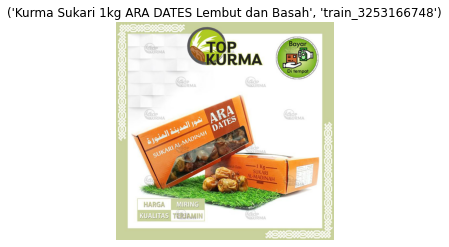

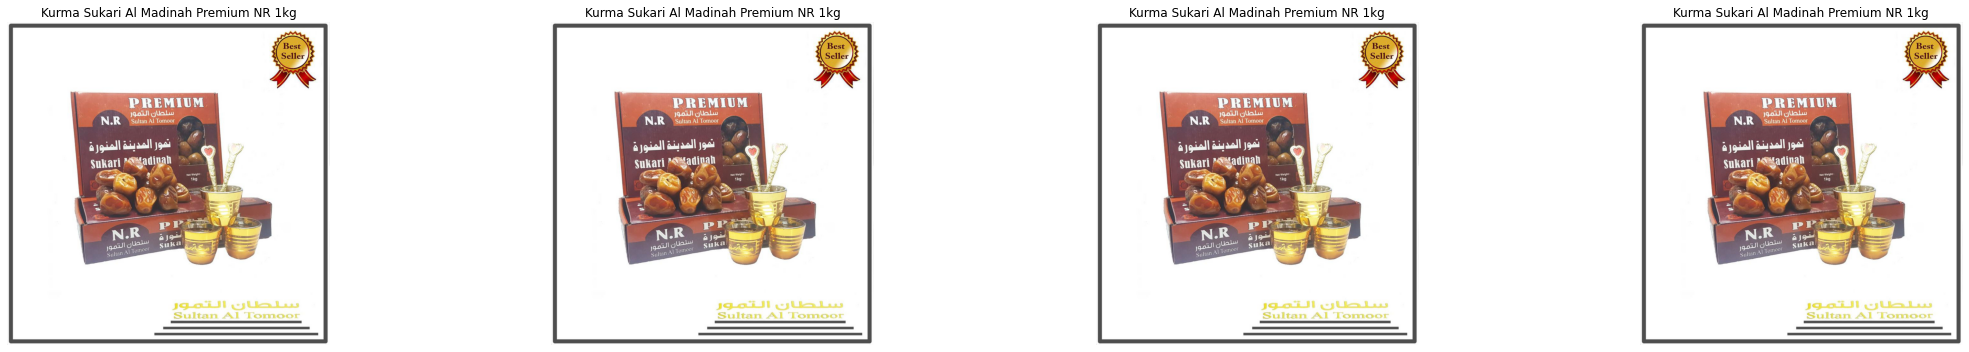

In [135]:
index =1
for item in postingid_list:
    imagePath = '/content/train_images/'+ image_list[index]
    pil_im = Image.open(imagePath, 'r')
    plt.figure()
    plt.imshow(pil_im)
    plt.axis('off')  
    plt.title(f'{title_list[index],key_list[index]}') 
    plt.show()
    matching_indices = matches_list[index].split(' ')
    matching_indices = matching_indices[:len(matching_indices)-1][:4]
    n_images = len(matching_indices)
  
    figure, axes = plt.subplots(1,n_images,  figsize = (32,5)) 
    for ind in matching_indices:
      for ax in axes:
        image_path = '/content/train_images/'+ image_list[int(ind)]
        img = plt.imread(image_path) 
        ax.set_title(title_list[int(ind)])
        ax.axis('off')   
        ax.imshow(img)
    index= index +1
    if index == 2:
        break 
plt.tight_layout()
plt.show()  